# Steel Plate Defect Prediction


<img src='https://www.thinmetalsales.com/wp-content/uploads/METAL-METAL-METAL-METAL-METAL-METAL-METAL-METAL-METAL-MANUFACTURING-1.jpg' />


This is a KAGGLE Competition on predicting the probability of various defects on steel plates.

There are 7 defect types: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The objective is to predict the probability of each of the 7 binary targets of the test set. 

The data is already split in Train and Test sets. The Train set will be used to train the model and the Test set will be used to make prediction for the competition submission.


**Defects**

Before continuing with creating the predictive models, in this section are explained each of the steel plate defect types.

* <code>Pastry</code>: Pastry are small patches on the surface of the steel plate. These imperfections can affect the surface smoothness and appearance of the steel plate.

* <code>Z_Scratch</code>: Z-scratches are narrow scratches or marks on the surface of the steel plate that run parallel to the rolling direction.

* <code>K_Scratch</code>: K-scratches are similar to Z-scratches but run perpendicular to the rolling direction. 

* <code>Stains</code>: Stains refer to discolored or contaminated areas on the surface of the steel plate.

* <code>Dirtiness</code>: Dirtiness indicates the presence of dirt or particulate matter on the surface of the steel plate.

* <code>Bumps</code>: Bumps are raised or protruding areas on the surface of the steel plate. 

* <code>Other_Faults</code>: This could include various types of surface imperfections, irregularities, or abnormalities that affect the quality of the steel plate.

## Importing Libraries

In [153]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import catboost
from catboost import CatBoostClassifier

## Reading the data

In [60]:
# Setting the pandas condition to display all columns of the dataframes

pd.set_option('display.max_columns', None)

In [61]:
# Locating the zip file in this directory
file = zipfile.ZipFile('..\Data\playground-series-s4e3.zip')

# Printing the filelist
for i in file.filelist:
    print(i.filename)

sample_submission.csv
test.csv
train.csv


In [106]:
# Openning the zip file and reading the provided csv file from KAGGLE

with file.open('train.csv') as t:
    df_train = pd.read_csv(t)
    
    
with file.open('test.csv') as te:
    df_test = pd.read_csv(te)

## Exploring the df

In [107]:
print('The train df contains {} rows and {} columns'.format(df_train.shape[0], df_train.shape[1]))

print('The test df contains {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))

The train df contains 19219 rows and 35 columns
The test df contains 12814 rows and 28 columns


In [108]:
# Showing a sample of the dataset

df_train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [109]:
# Defining the targets of the dataset (7 types of steel plate defects)

targets = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

Before continuing, lets check the values of the targets: <code>["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]</code>. <br>
The targets are binay, meaning that they would have values 0 and 1 and each column represents a different defect as mentioned above. In the secion below, we will check whether we have cases with more than one defect or if we have cases without defect.

In [110]:
# Checking whether we have targets without faults or with more than one fault

df_train[targets].sum(axis=1).value_counts()

1    18380
0      818
2       21
dtype: int64

From above, we can understand that we have cases without any defect **(818 cases)** and cases than have more than one defect **(21 Cases)**. <br>
Since our goal is to predict the type of defect in the SteelPlate rather than simply determining whether it has a defect or not, we will exclude the 818 cases that do not exhibit any defects. <br>
For the cases that have more than one defect, we will analyze them to check whether we should take any action.

In [111]:
# Removing cases with no fault

df_train = df_train[df_train[targets].sum(axis=1) > 0]

In [113]:
# Cases with more than one defect
multiple_targets_rows = df_train[targets].sum(axis=1) > 1
df_train.loc[multiple_targets_rows][targets]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1
8538,0,0,1,0,0,0,1


Since all the cases are "K_Scatch" cases, we will set the value 0 to other defects for these 21 rows

In [114]:
# Setting other target columns to 0 for rows with multiple targets
df_train.loc[multiple_targets_rows, targets[:]] = 0

# Setting "K_Scatch" to 1 for rows with multiple targets
df_train.loc[multiple_targets_rows, "K_Scatch"] = 1

In [115]:
# Checking again the targets values

df_train[targets].sum(axis=1).value_counts()

1    18401
dtype: int64

In [116]:
# Concatening train and the test sets in one dataframe

total_df = pd.concat([df_train, df_test])

In [117]:
# Checking the null values of the df

total_df.isnull().sum()

id                           0
X_Minimum                    0
X_Maximum                    0
Y_Minimum                    0
Y_Maximum                    0
Pixels_Areas                 0
X_Perimeter                  0
Y_Perimeter                  0
Sum_of_Luminosity            0
Minimum_of_Luminosity        0
Maximum_of_Luminosity        0
Length_of_Conveyer           0
TypeOfSteel_A300             0
TypeOfSteel_A400             0
Steel_Plate_Thickness        0
Edges_Index                  0
Empty_Index                  0
Square_Index                 0
Outside_X_Index              0
Edges_X_Index                0
Edges_Y_Index                0
Outside_Global_Index         0
LogOfAreas                   0
Log_X_Index                  0
Log_Y_Index                  0
Orientation_Index            0
Luminosity_Index             0
SigmoidOfAreas               0
Pastry                   12814
Z_Scratch                12814
K_Scatch                 12814
Stains                   12814
Dirtines

We don't have any null values in this DataFrame. The null values are present only in the target labels, with the exact number matching the length of the test DataFrame

In [118]:
# Descriptive Analysis of the train df

total_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,31215.000000,31215.000000,31215.000000,3.121500e+04,3.121500e+04,31215.000000,31215.000000,31215.000000,3.121500e+04,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000
mean,16184.768637,708.190165,752.525677,1.854290e+06,1.850125e+06,1698.853019,96.685247,64.708794,1.941326e+05,84.479609,128.606792,1459.892007,0.404934,0.594073,75.791286,0.352177,0.408512,0.575053,0.030935,0.616627,0.832003,0.588009,2.476561,1.314108,1.390051,0.100283,-0.139447,0.572199,0.079615,0.062497,0.186512,0.030868,0.026357,0.258736,0.355415
std,9263.945473,532.447505,500.594578,1.911864e+06,1.904240e+06,3750.566565,196.998473,143.845935,4.609339e+05,28.735434,14.115994,145.893711,0.490887,0.491078,53.312520,0.318855,0.124000,0.258672,0.048201,0.221140,0.221335,0.482747,0.764101,0.470280,0.404021,0.487294,0.118440,0.332374,0.270704,0.242062,0.389530,0.172964,0.160200,0.437952,0.478652
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,4.000000,2.000000,2.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.066700,0.000000,0.778200,0.301000,0.000000,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8157.500000,46.000000,214.000000,6.574680e+05,6.531950e+05,90.000000,15.000000,14.000000,9.948000e+03,68.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.316700,0.375800,0.006600,0.454500,0.655700,0.000000,1.954200,1.000000,1.079200,-0.272700,-0.192600,0.257000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16294.000000,775.000000,793.000000,1.398598e+06,1.398179e+06,169.000000,25.000000,24.000000,1.832700e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413000,0.545400,0.009500,0.636400,0.965500,1.000000,2.227900,1.146100,1.322200,0.111100,-0.143500,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24228.500000,1152.000000,1165.500000,2.368336e+06,2.368203e+06,657.000000,65.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.653450,0.493700,0.818200,0.019100,0.785700,1.000000,1.000000,2.817600,1.431400,1.707600,0.526300,-0.084400,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,32032.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.747200,1.000000,1.000000,1.000000,4.680200,2.997300,4.258700,0.991700,0.591700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
# Checking if we have duplicated values

total_df.duplicated().sum()

0

There are no duplicate values on the df

# EDA (Exploratory Data Analysis)

In [120]:
sns.set_style('darkgrid')

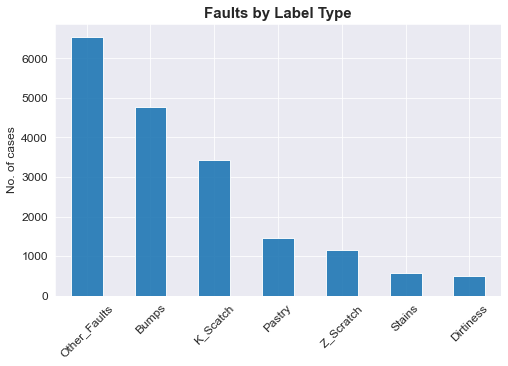

In [121]:
# Plotting Faults by the label type

faults_by_type = df_train[targets].sum().sort_values(ascending = False)

faults_by_type.plot(kind='bar', alpha = 0.9, figsize=(8,5))
plt.title('Faults by Label Type', fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize=12)
plt.ylabel('No. of cases', fontsize=12)

plt.show()

From the above chart we can observe that the majority of the cases are "Other_Faults", followed by "Bumps" and "K_Scatch"

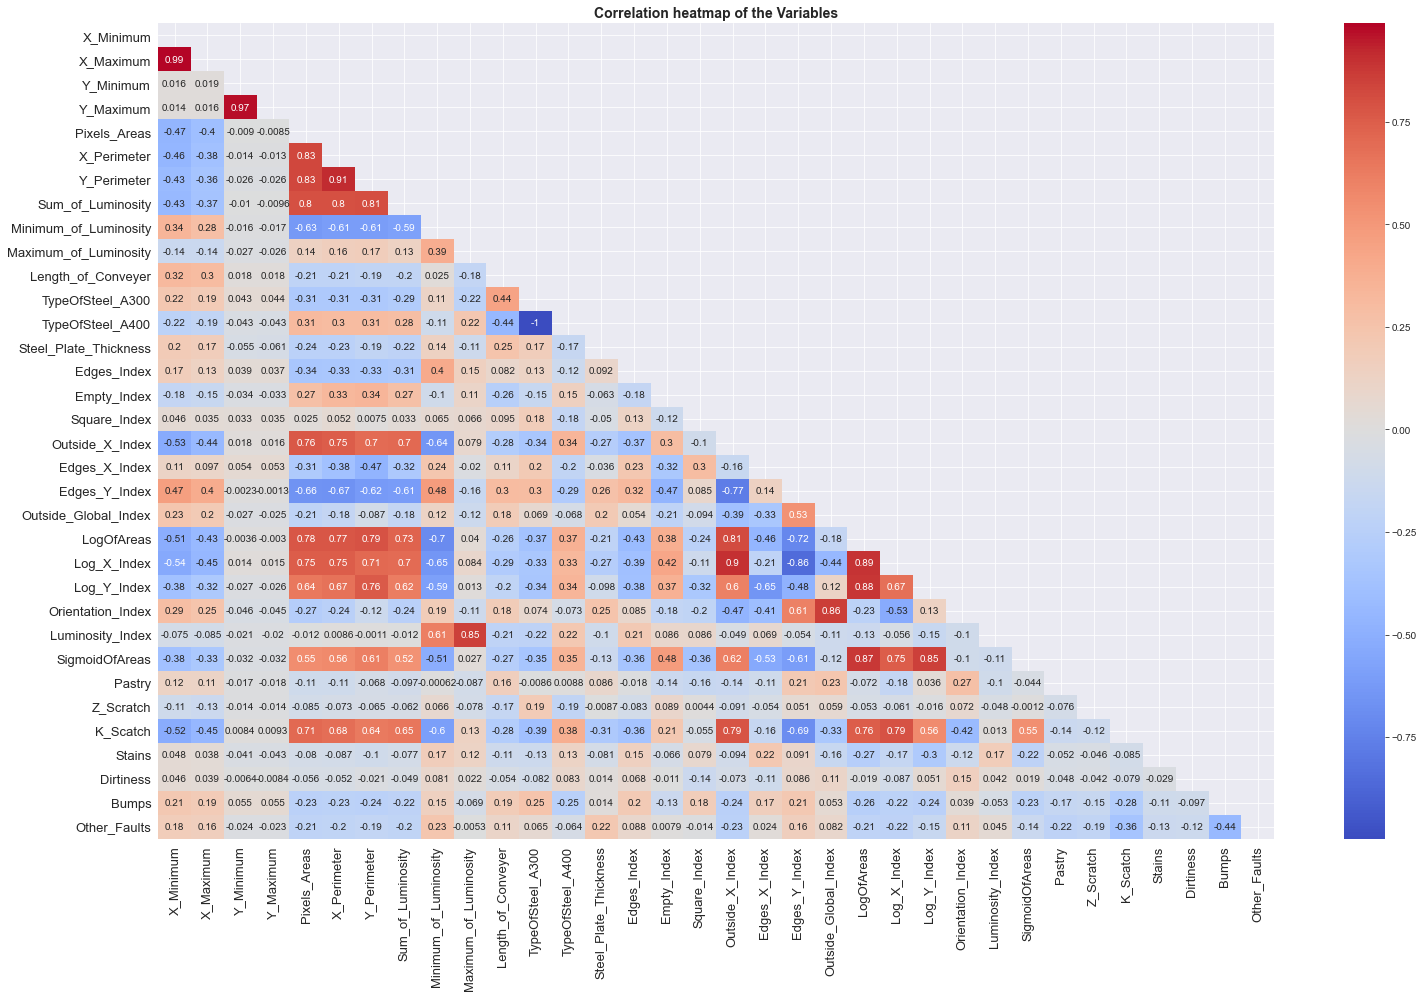

In [122]:
# Plotting the heatmap of correlations between features

fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data=df_train.drop('id',axis=1).corr(), 
        annot=True, 
        mask = np.triu(np.ones_like(df_train.drop('id',axis=1).corr(), dtype=bool)),
           cmap='coolwarm')

plt.title('Correlation heatmap of the Variables', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

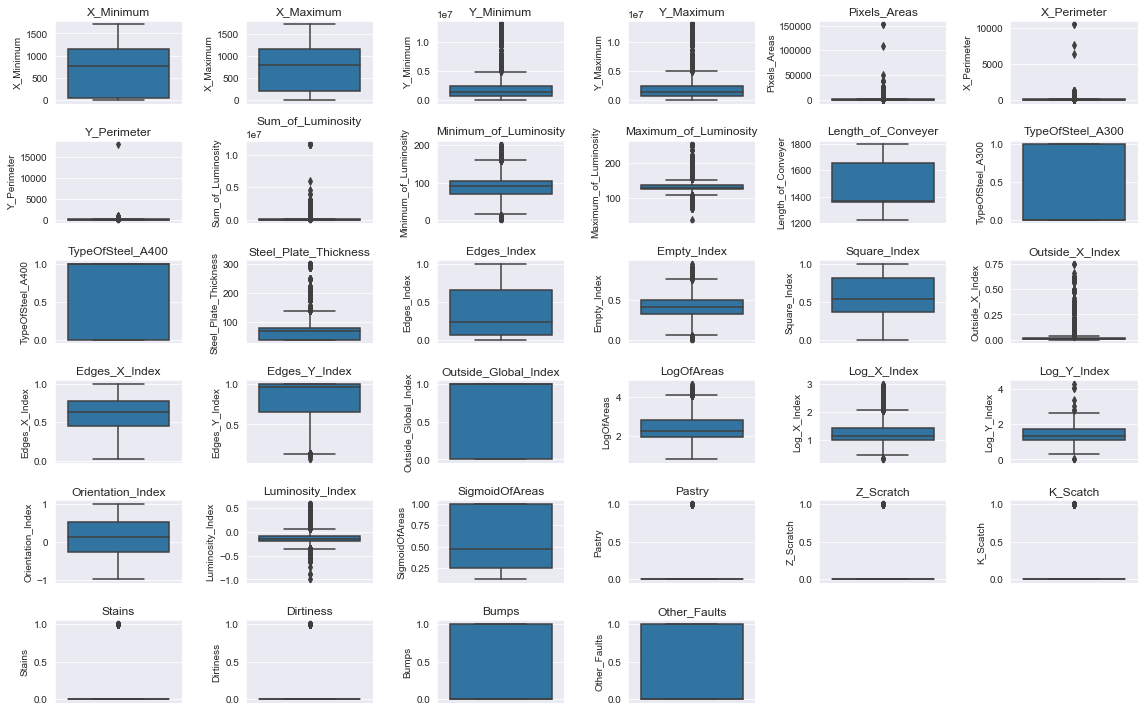

In [123]:
# Plotting the distribution of the columns

plt.figure(figsize=(16, 10))

for i, column in enumerate(total_df.drop('id',axis=1), start=1):
    plt.subplot(6, 6, i)
    sns.boxplot(y=total_df[column])
    plt.title(column)

plt.tight_layout()
plt.show();

As it is seen above many features exhibit a wide range of values. These points could be critical factors in the model's construction.

## Feature Engineering

In [124]:
# Creating a function for feature engineering

def feature_engineering(df):
    """
    This function is created to make the feature engineering process of this dataset
    """
    # Calculating the X_distance from X_Maximum and X_Minimum
    df['X_distance'] = df['X_Maximum'] - df['X_Minimum']
    
    # Calculating the Y_distance from Y_Maximum and Y_Minimum
    df['Y_distance'] = df['Y_Maximum'] - df['Y_Minimum']
    
    # Calculating the difference of Maximum_of_Luminosity and Minimum_of_Luminosity
    df['Color_contrast'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']
    
    # Calculating the Density
    df['Density'] = df['Pixels_Areas'] / (df['X_Perimeter'] + df['Y_Perimeter'])
    
    return df

In [125]:
# Calculating the feature engineered columns

total_df = feature_engineering(total_df)

In [126]:
# Showing a sample of the df
total_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_distance,Y_distance,Color_contrast,Density
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,5,27,1.230769
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,22,41,5.851351
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,153,68,112,10.122667
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,27,20,4.666667
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,45,29,3.748201


## Training the models

### Splitting the data into train and test sets

In [127]:
# Spliting train and test df after processing

# Train df
train_df = total_df[:df_train.shape[0]]

# Test df
test_df = total_df[df_train.shape[0]:].dropna(axis=1)

In [128]:
# Dropping the 'id' column from train df
train_df = train_df.drop('id', axis=1).copy()

train_df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_distance,Y_distance,Color_contrast,Density
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,5,27,1.230769
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,22,41,5.851351
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,153,68,112,10.122667
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,27,20,4.666667
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,45,29,3.748201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,143210,143219,17,4,4,2193,122,140,1360,0,0,50,0.8950,0.1500,0.8571,0.0044,1.0000,0.8000,0.0,1.2305,0.7782,0.6021,-0.1429,0.0044,0.2901,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8,9,18,2.125000
19215,723,735,2488529,2488541,231,17,26,27135,104,133,1652,1,0,70,0.9243,0.3254,0.2778,0.0065,0.7333,0.9216,1.0,2.3636,1.0414,1.4150,0.7222,-0.0989,0.5378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12,12,29,5.372093
19216,6,31,1578055,1578129,780,114,98,71112,41,94,1358,0,1,200,0.0148,0.4331,0.2281,0.0199,0.1862,0.9554,1.0,2.8921,1.4314,1.8692,0.7719,-0.4283,0.9997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25,74,53,3.679245
19217,9,18,1713172,1713184,126,13,26,14808,88,132,1692,1,0,60,0.0192,0.2361,0.0390,0.0068,0.7692,1.0000,1.0,2.1004,1.0414,1.4150,0.9610,-0.1162,0.3509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9,12,44,3.230769


### Scaling the features

Based on the researches, when we use regularization techniques it is better to scale the data. In this notebook we intend to use models with regularization included

In [129]:
# Getting the features in a list from the train df

features=list(train_df.drop(columns=targets,axis=1))

From all the features, we have only two categorical variables: 'TypeOfSteel_A300','TypeOfSteel_A400'

In [130]:
# Identifying categorical variables

cat_features=['TypeOfSteel_A300','TypeOfSteel_A400']

In [131]:
# Defining columns to scale (Excluding cat_features)

scale_cols = features.copy()
for f in cat_features:
    scale_cols.remove(f)

In [138]:
# Scaling the train and thest sets using StandardScaler
scaler = StandardScaler()
train_df.loc[:, scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df.loc[:, scale_cols] = scaler.transform(test_df[scale_cols])

### Defining features and targets (X, y)

In [141]:
X = train_df.drop(targets, axis = 1)

y = train_df[targets]

y_arr = y.to_numpy()

y_arr = np.argmax(y_arr, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_arr,
                                                    test_size=0.2,
                                                    random_state=42)

### Models

#### Xgboost Model

In [142]:
# %%time

# #Performing the random search on Xgboost Model
# # Define the parameter grid
# param_grid = {
    
#     'learning_rate': [0.00988, 0.01],# , 0.1],
#     'max_depth': [4],#, 5, 6, 7],
#     'subsample': [0.75, 0.8],# , 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.65],#, 0.9, 1.0],
#     'reg_alpha': [0.16, 0.17],#, 0.5, 1.0],
#     'reg_lambda': [0.8, 0.85, 0.75],#, 0.5, 1.0],
#     'n_estimators': [900], #, 400, 600, 800, 1000],
#      #'subsample_for_bin': [140000, 130000],
#                    }


# # Create XGBClassifier
# xgb = XGBClassifier()

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=3, scoring='roc_auc', cv=5, verbose=1, random_state=42)

# # Fit the random search model
# random_search.fit(X_train, y_train)

# # Get the best parameters and the best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best accuracy found: ", random_search.best_score_)

# # # Fit the model with best parameters
# best_xgb = random_search.best_estimator_
# best_xgb.fit(X_train, y_train)

In [143]:
# # Get the predicted probabilities for the positive class
# y_prob = best_xgb.predict_proba(X_test)

# # Calculate ROC-AUC score
# roc_auc = roc_auc_score(y_test, y_prob)
# print("ROC-AUC Score:", roc_auc)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 5), 
        'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.02, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9, log=True), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.75, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.11, 0.195, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.55, 0.95, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 880, 920) 
    }

In [66]:
# Define objective function
def objective(trial):
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 6), 
        'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.03, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.95, log=True), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.95, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.11, 0.55, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 0.95, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 880, 980) 
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test) #[:, 1]
    score = roc_auc_score(y_test, y_pred,multi_class='ovr')
    return score

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=100)
#study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# Access the best hyperparameters
best_params = study.best_params
best_score = study.best_value

print("Best score:", best_score)
print("Best parameters:", best_params)

In [63]:
print('Best parameters from Optuna for XGboost model are: ')
print(best_params)

Best parameters from Optuna for XGboost model are: 
{'max_depth': 5, 'learning_rate': 0.011446115343739438, 'subsample': 0.4683890227422993, 'colsample_bytree': 0.33980945038141824, 'reg_alpha': 0.2380984714284755, 'reg_lambda': 0.5324894311528886, 'n_estimators': 893}


In [146]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params = {'max_depth': 5, 
               'learning_rate': 0.011446115343739438, 
               'subsample': 0.4683890227422993, 
               'colsample_bytree': 0.33980945038141824, 
               'reg_alpha': 0.2380984714284755, 
               'reg_lambda': 0.5324894311528886, 
               'n_estimators': 893}

In [147]:
# Training the model again with the selected features

xgb1 = XGBClassifier(**best_params)

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.33980945038141824, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011446115343739438,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=893, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [148]:
# Getting the predicted probabilities for the positive class
y_prob = xgb1.predict_proba(X_test)

# Calculateing ROC-AUC score 
roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class='ovo')
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print("ROC-AUC-OVO Score:", roc_auc_ovo)
print("ROC-AUC-OVR Score:", roc_auc_ovr)

ROC-AUC-OVO Score: 0.902854493066872
ROC-AUC-OVR Score: 0.8927915641513708


#### LightGBM

In [149]:
#     param = {
#         "objective": "multiclass",
#         #"metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "num_class": 7,
#         "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.015),
#         "n_estimators": trial.suggest_int("n_estimators", 850, 920),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.025),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#         "max_depth": trial.suggest_int("max_depth", 4, 7),
#         "num_leaves": trial.suggest_int("num_leaves", 25, 60),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
#     }

In [150]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        #"metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.02),
        "n_estimators": trial.suggest_int("n_estimators", 880, 1300),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.01, 0.55),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.01, 0.55),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.95),
        "subsample": trial.suggest_float("subsample", 0.15, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 75),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)
    
    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    # score = lgbm_classifier.score(X_test, y_test)
    
    y_pred_lgb = lgbm_classifier.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_lgb, multi_class='ovr')
    
    print(f'SCORE: {score}')

    return score

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)


# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100) # n_trials=25

# Get the best parameters after optimization
# Access the best hyperparameters
best_params_lgb = study.best_params
best_score_lgb = study.best_value

print("Best score:", best_score_lgb )
print("Best parameters:", best_params_lgb)

In [70]:
print('Best parameters from Optuna for LightGBM model are: ')
print(best_params_lgb)

Best parameters from Optuna for LightGBM model are: 
{'learning_rate': 0.011451844520852525, 'n_estimators': 892, 'lambda_l1': 0.51579494580044, 'lambda_l2': 0.41876546915108137, 'max_depth': 4, 'num_leaves': 65, 'colsample_bytree': 0.22216512167100838, 'subsample': 0.6364183173814645, 'min_child_samples': 71}


In [151]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params_lgb1 = {
         "objective": "multiclass",
        #"metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
         'learning_rate': 0.011451844520852525,
         'n_estimators': 892,
         'lambda_l1': 0.51579494580044,
         'lambda_l2': 0.41876546915108137,
         'max_depth': 4,
         'num_leaves': 65,
         'colsample_bytree': 0.22216512167100838,
         'subsample': 0.6364183173814645,
         'min_child_samples': 71}

In [72]:
# Training the model again with the selected features

lgb1 = LGBMClassifier(**best_params_lgb1)

lgb1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.22216512167100838, lambda_l1=0.51579494580044,
               lambda_l2=0.41876546915108137,
               learning_rate=0.011451844520852525, max_depth=4,
               min_child_samples=71, n_estimators=892, num_class=7,
               num_leaves=65, objective='multiclass', random_state=42,
               subsample=0.6364183173814645, verbosity=-1)

In [152]:
# Get the predicted probabilities for the positive class
y_prob_lgb = lgb1.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_lgb = roc_auc_score(y_test, y_prob_lgb, multi_class='ovo')
roc_auc_ovr_lgb = roc_auc_score(y_test, y_prob_lgb, multi_class='ovr')

print("ROC-AUC-OVO Score LGB:", roc_auc_ovo_lgb)
print("ROC-AUC-OVR Score LGB:", roc_auc_ovr_lgb)

ROC-AUC-OVO Score LGB: 0.9033397073930209
ROC-AUC-OVR Score LGB: 0.8922672053091595


#### Catboost

In [154]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "verbose": False,
        "random_seed": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.02),
        "iterations": trial.suggest_int("iterations", 800, 1000),
        "depth": trial.suggest_int("depth", 3, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.2, 1.0),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    cat_classifier = CatBoostClassifier(**param)
    
    # Fit the classifier on the training data
    cat_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    #score = lgbm_classifier.score(X_test, y_test)
    
    y_pred_cat = cat_classifier.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_cat, multi_class='ovr')
    
    print(f'SCORE: {score}')

    return score

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)


# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

# Get the best parameters after optimization
# Access the best hyperparameters
best_params_cat = study.best_params
best_score_cat = study.best_value

print("Best score:", best_score_cat)
print("Best parameters:", best_params_cat)

In [77]:
print('Best parameters from Optuna for CatBoost model are: ')
print(best_params_cat)

Best parameters from Optuna for CatBoost model are: 
{'learning_rate': 0.019390566919942964, 'iterations': 957, 'depth': 5, 'l2_leaf_reg': 2.0827875117527705, 'bagging_temperature': 0.4536925527900938}


In [79]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params_cat1 = {
         "verbose": False,
        "random_seed": 42,
    
    'learning_rate': 0.019390566919942964, 
    'iterations': 957, 
    'depth': 5, 
    'l2_leaf_reg': 2.0827875117527705, 
    'bagging_temperature': 0.4536925527900938}

In [80]:
# Training the model again with the selected features

cat1 = CatBoostClassifier(**best_params_cat1)

cat1.fit(X_train, y_train)

In [155]:
# Get the predicted probabilities for the positive class
y_prob_cat = cat1.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_cat = roc_auc_score(y_test, y_prob_cat, multi_class='ovo')
roc_auc_ovr_cat = roc_auc_score(y_test, y_prob_cat, multi_class='ovr')

print("ROC-AUC-OVO Score CAT:", roc_auc_ovo_cat)
print("ROC-AUC-OVR Score CAT:", roc_auc_ovr_cat)

ROC-AUC-OVO Score CAT: 0.9014996098549881
ROC-AUC-OVR Score CAT: 0.8914519991487911


#### Voting Regressor Model

In [156]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the weighted ensemble
    
    obj_estimators = [
        ('LGBM', LGBMClassifier(**best_params_lgb1)),
        ('XGB', XGBClassifier(**best_params)),
        ('CAT', CatBoostClassifier(**best_params_cat1))
    ]
    
    voting_classifier = VotingClassifier(
        estimators=obj_estimators,
        voting='soft',
        weights=[
            trial.suggest_float('LGBM_Weight', 0.00, 10.00),
            trial.suggest_float('XGB_Weight', 0.00, 10.00),
            trial.suggest_float('CAT_Weight', 0.00, 10.00),
        ],
    )
    
    voting_classifier.fit(X_train, y_train)
    
    predict_probs = voting_classifier.predict_proba(X_test)
    
    auc_score = roc_auc_score(y_test, predict_probs, multi_class='ovr')

    return auc_score

# Set up the sampler for Optuna optimization
weight_sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
weight_study = optuna.create_study(direction="maximize", sampler=weight_sampler)

# Run the optimization process
weight_study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

# Get the best parameters after optimization
weight_best_params = weight_study.best_params
    
print(f'BEST WEIGHTS: {weight_best_params}')

In [158]:
# If you do not run the optuna function above, here are the best weights that the optimizer gave:
weight_best_params = {'LGBM_Weight': 6.839438822704465, 'XGB_Weight': 8.038255036495546, 'CAT_Weight': 7.348741864835092}

In [157]:
print('Best weights from Optuna for the voting model are: ')
print(weight_best_params)

Best weights from Optuna for the voting model are: 
{'LGBM_Weight': 6.839438822704465, 'XGB_Weight': 8.038255036495546, 'CAT_Weight': 7.348741864835092}


In [87]:
obj_estimators = [
        ('LGBM', LGBMClassifier(**best_params_lgb1)),
        ('XGB', XGBClassifier(**best_params)),
        ('CAT', CatBoostClassifier(**best_params_cat1))
    ]

In [88]:
voting_classifier = VotingClassifier(
    estimators=obj_estimators,
    voting='soft',
    weights=[
        6.839438822704465,
        8.038255036495546,
        7.348741864835092,
    ],
)

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(colsample_bytree=0.22216512167100838,
                                             lambda_l1=0.51579494580044,
                                             lambda_l2=0.41876546915108137,
                                             learning_rate=0.011451844520852525,
                                             max_depth=4, min_child_samples=71,
                                             n_estimators=892, num_class=7,
                                             num_leaves=65,
                                             objective='multiclass',
                                             random_state=42,
                                             subsample=0.6364183173814645,
                                             verbosity=-1)),
                             ('XGB',
                              XGB...
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=893, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x0000012DAB112CD0>)],
                 voting='soft',
                 weights=[6.839438822704465, 8.038255036495546,
                          7.348741864835092])

In [89]:
# Get the predicted probabilities for the positive class
y_prob_vot = voting_classifier.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_vot = roc_auc_score(y_test, y_prob_vot, multi_class='ovo')
roc_auc_ovr_vot = roc_auc_score(y_test, y_prob_vot, multi_class='ovr')
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovo_vot)
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovr_vot)

ROC-AUC-VOT-OVO Score: 0.9039120994757539
ROC-AUC-VOT-OVO Score: 0.8934236947924807


#### Stacking Classifier Model

In [93]:
# Define the base estimators
base_estimators = [
    ('LGBM', LGBMClassifier(**best_params_lgb1)),
    ('XGB', XGBClassifier(**best_params)),
    ('CAT', CatBoostClassifier(**best_params_cat1))
]

# Initialize the stacking classifier with the base estimators and meta-estimator
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression()  # meta-estimator here
)

# Fit the stacking classifier
stacking_classifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('LGBM',
                                LGBMClassifier(colsample_bytree=0.22216512167100838,
                                               lambda_l1=0.51579494580044,
                                               lambda_l2=0.41876546915108137,
                                               learning_rate=0.011451844520852525,
                                               max_depth=4,
                                               min_child_samples=71,
                                               n_estimators=892, num_class=7,
                                               num_leaves=65,
                                               objective='multiclass',
                                               random_state=42,
                                               subsample=0.6364183173814645,
                                               verbosity=-1)),
                               ('XGB',
                                X...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=893, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('CAT',
                                <catboost.core.CatBoostClassifier object at 0x0000012DA560EC10>)],
                   final_estimator=LogisticRegression())

In [94]:
# Get the predicted probabilities for the positive class
y_prob_stack = stacking_classifier.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_sta = roc_auc_score(y_test, y_prob_stack, multi_class='ovo')
roc_auc_ovr_sta = roc_auc_score(y_test, y_prob_stack, multi_class='ovr')
print("ROC-AUC-STA-OVO Score:", roc_auc_ovo_sta)
print("ROC-AUC-STA-OVR Score:", roc_auc_ovr_sta)

ROC-AUC-STA-OVO Score: 0.8924392807563061
ROC-AUC-STA-OVR Score: 0.8829569763995434


### Comparng the Models

In [95]:
print('Xgboost {}'.format(roc_auc_ovr))
print('LightGBM {}'.format(roc_auc_ovr_lgb))
print('Catboost {}'.format(roc_auc_ovr_cat))
print('Voting {}'.format(roc_auc_ovr_vot))
print('Stacking {}'.format(roc_auc_ovr_sta))

Xgboost 0.8927915641513708
LightGBM 0.8922672053091595
Catboost 0.8914519991487911
Voting 0.8934236947924807
Stacking 0.8829569763995434


Based on ROC AUC Score (Receiver Operating Characteristic Area Under the Curve), the voting model performs the best. We will use this model to make predictions

### Classification Report & Confusion Matrix

In [159]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob_vot, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.42      0.17      0.24       283
   Z_Scratch       0.63      0.62      0.63       247
    K_Scatch       0.91      0.89      0.90       700
      Stains       0.69      0.84      0.76       124
   Dirtiness       0.57      0.20      0.29        86
       Bumps       0.58      0.50      0.54       985
Other_Faults       0.48      0.62      0.54      1256

    accuracy                           0.60      3681
   macro avg       0.61      0.55      0.56      3681
weighted avg       0.60      0.60      0.59      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

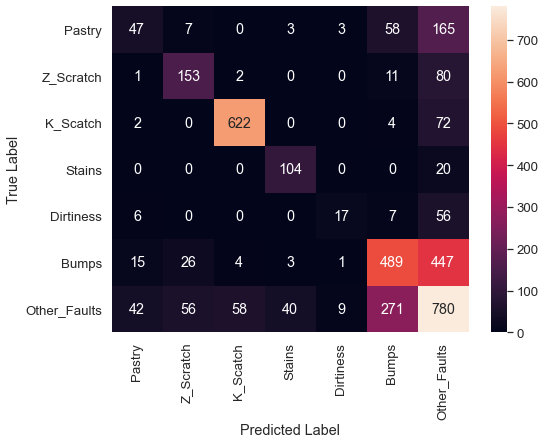

In [160]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob_vot, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Predicting the Test Data

In [97]:
test_df

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,X_distance,Y_distance,Color_contrast,Density
0,19219,0.577290,0.561442,1.030498,1.037714,-0.280779,-0.411819,-0.183693,-0.297574,-0.606287,-0.110691,1.346747,0,1,1.396166,0.115433,0.655781,-0.960645,-0.451208,-0.225640,0.762315,0.849777,0.472194,-0.427634,0.669131,1.177353,-0.729622,1.037547,-0.328180,0.008512,0.595073,0.587550
1,19220,1.031459,1.036976,-0.754314,-0.755997,-0.357482,-0.395088,-0.360571,-0.349262,0.263219,0.246460,-0.725407,0,1,-0.671877,-0.589761,0.041123,-1.862352,-0.551469,-1.686366,0.762315,0.849777,0.116136,-0.874135,0.137582,1.657309,-0.049660,1.017106,-0.377514,0.008488,-0.154281,0.170707
2,19221,1.221009,1.238778,-0.912669,-0.915143,-0.378979,-0.339318,-0.321265,-0.371465,0.576242,0.389320,-0.684239,0,1,-0.671877,-0.909734,1.737904,-0.385637,-0.325882,-0.068650,-0.363606,-1.223429,-0.023912,0.013572,-0.170598,-1.280984,0.807025,0.238513,-0.377514,0.008479,-0.416555,-0.231152
3,19222,-1.031067,-1.166864,-0.852574,-0.854741,-0.434449,-0.484320,-0.527622,-0.418080,0.784923,0.817902,1.580036,1,0,0.456146,0.291731,-0.608313,0.935064,-0.572356,0.833590,0.762315,0.849777,-0.751952,-1.306445,-0.862894,0.168747,0.552039,-1.103130,-0.426849,0.008514,-0.416555,-0.299184
4,19223,-0.278498,-0.319694,-0.689130,-0.690488,-0.418525,-0.434127,-0.488316,-0.402531,0.645802,0.389320,1.566313,1,0,-0.295869,1.468728,-1.185768,-0.569454,-0.319616,1.023511,-1.339554,-1.223429,-0.434789,0.013572,-0.604762,-1.378783,0.420760,-0.466128,-0.143175,0.008490,-0.491490,-0.251594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,32028,0.738689,0.727279,-0.739653,-0.741244,-0.372610,-0.361626,-0.272132,-0.388907,-0.188924,-1.825018,-0.732269,0,1,-0.107865,-0.205794,-0.837192,-1.321327,-0.386457,-0.942469,0.399318,0.849777,0.021248,-0.180660,0.596893,1.369253,-1.443246,0.953976,-0.365181,0.008565,-0.753764,-0.186943
12810,32029,1.091514,1.106907,0.675763,0.681224,-0.440023,-0.489897,-0.458837,-0.425558,0.993605,0.889332,-0.670516,0,1,-0.671877,-1.067524,-1.057175,-1.151799,-0.541025,0.733441,0.762315,0.849777,-0.924630,-0.996986,-0.335536,1.279056,0.796085,-1.132290,-0.340513,0.008563,-0.603894,-0.550065
12811,32030,-1.250644,-1.082946,-0.142590,-0.141413,3.945821,3.899197,4.493740,3.726992,-2.101838,1.032193,-0.409781,0,1,-0.671877,-0.926046,1.260735,1.394220,1.932068,-1.783357,-1.896209,-1.223429,2.314482,1.979617,2.159243,-0.334016,0.499023,1.286456,1.534203,0.007719,2.805667,1.055842
12812,32031,1.166583,1.174840,-0.606422,-0.607359,-0.353235,-0.300279,-0.301612,-0.354681,-0.641067,-0.324982,-0.656793,0,1,-0.671877,-1.059054,-1.836821,-1.630263,-0.451208,-1.689524,0.762315,0.849777,0.140152,-0.427634,0.492359,1.533622,-1.039308,0.638331,-0.414515,0.008525,0.520137,-0.113308


In [102]:
test_df.drop('id', axis=1, inplace = True)

In [103]:
test_prediction_vot = voting_classifier.predict_proba(test_df)
test_prediction_vot = pd.DataFrame(test_prediction_vot, columns = y.keys())
submission_vot = pd.concat([test_ids, test_prediction_vot],axis = 1)
submission_vot

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.523779,0.003415,0.002587,0.000293,0.022639,0.133468,0.313820
1,19220,0.263169,0.025068,0.010408,0.000609,0.202626,0.166089,0.332030
2,19221,0.003542,0.039291,0.043641,0.001332,0.010754,0.394358,0.507083
3,19222,0.150219,0.005446,0.001289,0.002627,0.011760,0.364627,0.464034
4,19223,0.003562,0.004245,0.001869,0.002634,0.007637,0.649992,0.330060
...,...,...,...,...,...,...,...,...
12809,32028,0.074684,0.123314,0.005348,0.000594,0.041824,0.236361,0.517876
12810,32029,0.185043,0.006556,0.022614,0.013169,0.140087,0.208522,0.424008
12811,32030,0.000415,0.000651,0.950904,0.000154,0.000524,0.001043,0.046308
12812,32031,0.428012,0.010698,0.020535,0.000433,0.065359,0.143188,0.331773


In [105]:
submission_vot.to_csv('submission.csv', index = False)